In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from inference_toolbox.parameter import Parameter
from inference_toolbox.model import Model
from inference_toolbox.likelihood import Likelihood
from inference_toolbox.sampler import Sampler
from inference_toolbox.visualiser import Visualiser
from inference_toolbox.domain import Domain

from data_processing.normaliser import Normaliser
from data_processing.box_gridder import BoxGridder
# from gaussian_processor.gaussian_processor import GaussianProcessor

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# # Import and select data.
# all_data = pd.read_csv('data/total_data.csv')

# # Import and select metadata.
# metadata = pd.read_csv('data/data_summary.csv',
#     usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
# )

In [3]:

# normaliser = Normaliser(all_data, metadata)

# all_experiments = normaliser.get_experiments_list()

# selected_experiments = np.delete(all_experiments, np.where(all_experiments == 'Control'))

# normalised_data = normaliser.normalise_data(selected_experiments)

In [4]:
# box_gridder = BoxGridder(normalised_data)

# averaged_df = box_gridder.get_averages([200,200,50],False)

# # box_gridder.visualise_average_data(averaged_df)

# # averaged_df

In [5]:
# gp = GaussianProcessor(averaged_df, kernel = 'matern_white', data_norm='sqrt')
# training_data, test_data = gp.train_test_split()
# print(training_data)
# gp.train_gp(training_data)
# gp.test(test_data)
# grid = box_gridder.get_grid([10,10,10])
# gp.predict_from_gp(grid, threeD=True, save=True, log_results=True)
# gp.animate() 

import os

current_directory = os.getcwd()
if current_directory != '/project/':
    os.chdir('/project/')

In [6]:
# Get dummy data
log_dummy_data = pd.read_csv('data/log_dummy_data.csv')


In [7]:
# training_data, testing_data = train_test_split(averaged_df, test_size=0.2)
training_data, testing_data = train_test_split(log_dummy_data, test_size=0.2)

In [8]:
# Initialize parameter series
params = pd.Series({},dtype='float64')

# Parameter Assignment
I_y = Parameter(name = 'I_y', prior_select="gamma")
I_y.add_prior_param("mu",0.1)
I_y.add_prior_param("sigma",0.1)
params['I_y'] = I_y

I_z = Parameter(name = 'I_z', prior_select="gamma")
I_z.add_prior_param("mu",0.1)
I_z.add_prior_param("sigma",0.1)
params['I_z'] = I_z

Q = Parameter(name = 'Q', prior_select="gamma")
Q.add_prior_param("mu",3e13)
Q.add_prior_param("sigma",1e13)
params['Q'] = Q

# Model Assignment
model = Model('log_GPM_alt_norm')
model.add_model_param("H",10)

# Likelihood function assigmnent
likelihood = Likelihood("gaussian_fixed_sigma")
likelihood.add_likelihood_param("sigma",1)
# likelihood.add_likelihood_param("lambda_1",1)
# likelihood.add_likelihood_param("lambda_2",0.05)

# Initialize the sampler
sampler = Sampler(params, model, likelihood, training_data, show_sample_info = True)
hyperparams = sampler.get_hyperparams()

# Sample the parameters
params_samples = sampler.sample_all(10000, n_chains=1)

sample: 100%|██████████| 12500/12500 [00:03<00:00, 3229.49it/s, 7 steps of size 6.10e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       I_y      0.10      0.01      0.10      0.09      0.11   5544.13      1.00
       I_z      0.13      0.09      0.11      0.02      0.24   6162.62      1.00
         Q 30014990974976.00 1000670822400.00 30005019017216.00 28399703687168.00 31675874541568.00   6627.49      1.00

Number of divergences: 0


Creating instance
           I_y       I_z             Q
0     0.101477  0.068054  3.071777e+13
1     0.102311  0.098242  3.140127e+13
2     0.109768  0.093000  2.939189e+13
3     0.097959  0.235490  3.063650e+13
4     0.102918  0.077181  3.106629e+13
...        ...       ...           ...
9995  0.102553  0.089467  3.197178e+13
9996  0.103347  0.229800  2.969538e+13
9997  0.108184  0.122099  2.948554e+13
9998  0.103822  0.258177  2.937883e+13
9999  0.103204  0.176071  2.915292e+13

[10000 rows x 3 columns]


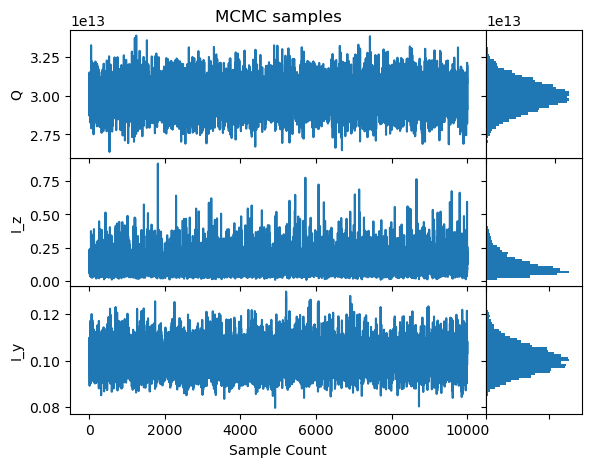

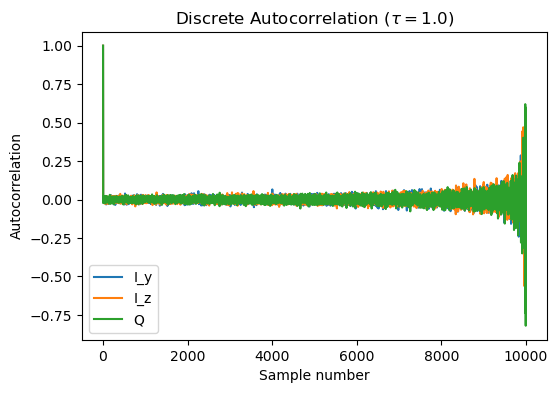

In [9]:
visualiser = Visualiser(testing_data, params_samples, model, hyperparams, previous_instance = sampler.instance, data_path = 'results/inference')
visualiser.save_samples()
visualiser.get_traceplot()
visualiser.get_autocorrelations()

# domain = Domain('cone_from_source_z_limited', resolution=80)
# domain.add_domain_param('r', 100)
# domain.add_domain_param('theta', np.pi/8)
# domain.add_domain_param('source', [0,0,10])

# visualiser.visualise_results(domain = domain, name = 'small_scale_3D_plots', title='Log Concentration of Droplets', log_results=False)
# visualiser.animate(name = 'small_scale_3D_plots')